In [1]:
#if needed, go for it
#!pip install geopy
#!pip install pandas
#!pip install sklearn
#!conda install cartopy
#!conda install -c conda-forge xarray dask netCDF4 bottleneck

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import os 
from datetime import datetime as dt
from datetime import timedelta
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
import warnings
#Visuals matplotlib +cartopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
#warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Drifter Data analysis between a year gap in the same area
This analysis is done for the 12 of october 2021 and 2022, for other days the proccess is roughly the same

#### Here we define some functions

In [3]:
def ordinal_to_dt(time):
    day = time%1 * 24
    hour = day%1 * 60
    seconds = hour%1 *60
    
    return dt.strptime(f"{int(day)}:{int(hour)}:{int(seconds)}", '%H:%M:%S') 

ordinal_to_dt = np.vectorize(ordinal_to_dt)

In [4]:
def compute_velocities(df):
    #We compute the geodesic distance using geopy function, for all the values of this drifter
    #The new column we are creating its going to be filled with the array defined in the for loop
    df['distance'] = [ 
        #compute the distance
        geodesic(
            [df.loc[i-1,'Latitude'],df.loc[i-1,'Longitude']], #pos i-1
            [df.loc[i,'Latitude'],df.loc[i,'Longitude']] #pos i
        ).m
        if i>0 #not for the first element to avoid errors
        else np.finfo(float).eps #instead we fill it with an infinitesimal value to avoid dividing by 0
        for i in range(len(df)) #for i position such as i is the number of elements
    ]
    #compute the time delta
    df['time_delta'] = [ 
        #by resting time(i-1) and time(i) and gettings the seconds of it
        np.abs((df.loc[i-1,'DeviceDateTime']-df.loc[i,'DeviceDateTime']).total_seconds())
        if i>0
        else 1
        for i in range(len(df))
    ]
    #The velocity will be de  division of this values
    df['velocity'] = df['distance']/df['time_delta']

    # apply normalization techniques for velocity visualization
    df['vel_normalized'] = MinMaxScaler().fit_transform(np.array(df['velocity']).reshape(-1,1))

    return df

#### Here we load every logsheet and we clean it a bit

In [5]:
logsheets_dir = './all_data_2022/Logsheet_2022'
logsheet_files = os.listdir(logsheets_dir)
logsheets = {}
#for every logsheet
for file in logsheet_files:
    #get the day from the filename
    day = file.split('_')[-1].split('-')[0]
    #load the logsheet with pandas
    logSheet = pd.read_csv(f'{logsheets_dir}/{file}',encoding='utf8')
    #get only the drifters
    logSheet = logSheet.loc[logSheet['Type']!='CTD']
    #Remove the id number extra digits, to get only the last 3 digits od the id, it is what we are using
    logSheet['id'] = logSheet['id'].apply(lambda x: str(int(x))[-3:])
    logSheet['Deployment'] = logSheet['Deployment'].apply(
        lambda x: dt.strptime(f'{x}:00', '%H:%M:%S') - timedelta(hours=2, minutes=0)
    )
    logSheet['Recovery'] = logSheet['Recovery'].apply(
        lambda x: dt.strptime(f'{x}:00', '%H:%M:%S') - timedelta(hours=2, minutes=0)
    )
    logsheets[day] = logSheet

In [6]:
logsheets['13']

,id,Type,Deployment,Lon,Lat,Recovery,Lon.1,Lat.1
2,052,White surface,1900-01-01 07:54:00,005º59.972,"43º4,813",1900-01-01 12:45:00,006º0.041,43º5.421
3,368,White surface,1900-01-01 07:54:00,005º59.972,"43º4,813",1900-01-01 12:39:00,005º59.593,43º5.133
4,274,Yellow,1900-01-01 07:54:00,005º59.972,"43º4,813",1900-01-01 12:41:00,005º59.716,43º5.224
5,436,White surface,1900-01-01 08:03:00,005º58.987,43º4.686,1900-01-01 11:52:00,005º58.677,43º4.495
6,439,White 60cm,1900-01-01 08:03:00,005º58.987,43º4.686,1900-01-01 11:55:00,005º58.499,43º4.402
7,279,Yellow,1900-01-01 08:03:00,005º58.987,43º4.686,1900-01-01 11:58:00,005º58.501,43º4.335
8,119,White 60cm,1900-01-01 08:21:00,005º58.416,43º4.669,1900-01-01 12:30:00,005º58.209,43º4.851
9,230,White surface,1900-01-01 08:21:00,005º58.416,43º4.669,1900-01-01 12:22:00,005º58.569,43º4.882
10,273,Yellow,1900-01-01 08:21:00,005º58.416,43º4.669,1900-01-01 12:24:00,005º58.265,43º4.949


In [7]:
#List of folder per day
drifter_folders = [i for i in os.listdir('./all_data_2022/') if 'MIR' in i]
#Dictionary to store all data
dataframes_all = {}
#for every folder
for folder in sorted(drifter_folders):
    day = '1'+folder.split('_')[-1][-1]
    print('Day',day)
    dataframes = []
    #for every file in that folder
    for file in sorted(os.listdir(f'./all_data_2022/{folder}')):
        print(f'\t{file}...')
        if file[-3:] == 'txt':
            #split filename by ".", get the second last, and get 3 last characters
            drifter_id = f'{file.split(".")[-2][-3:]}' 
            #read the csv, yes its a csv even if its termination its txt
            df = pd.read_csv(f'./all_data_2022/{folder}/{file}',encoding='utf8')
            #We rename the time column like the white data is
            df = df.rename(columns={
                "Reception time (UTC)": "DeviceDateTime",
                "Latitude (°)":"Latitude",
                "Longitude (°)":"Longitude",
            })
            #create a new colunm with the id
            df['DeviceName'] = drifter_id
            #We remove the data we are not goin to use
            df = df.drop(['Position time (UTC)', 'Course (°)','Speed (m/s)','Status','Battery (V)','Temperature (°C)'], axis=1)
            #order the columns like the white ones
            df = df.loc[:, ["DeviceName","DeviceDateTime","Latitude","Longitude"]]
            dataframes.append(df)

        elif file[-3:] == 'csv':
            drifter_id = f'{file.split(".")[-2][-3:]}'
            df = pd.read_csv(f'./all_data_2022/{folder}/{file}',encoding='utf8')
            #create a new colunm with the id
            df['DeviceName'] = drifter_id
            #We remove the data we are not goin to use
            df = df.drop(['BatteryStatus','CommId'], axis=1)
            #We remove erroneous data
            df = df.dropna()
        else:
            print(f'File {file} is not csv nor txt')
        #We append or dataframe to a list of them
        dataframes.append(df)
    #We concat them into a big dataframe
    dataframes_all[day] = pd.concat(dataframes)

Day 11
	LCI00273.txt...
	LCI00274.txt...
	LCI00277.txt...
	drifter-10_11_22-0119.csv...
	drifter-10_11_22-05_49.csv...
	drifter-10_11_22-2052.csv...
	drifter-10_11_22-3368.csv...
	drifter-10_11_22-6439.csv...
	drifter-10_11_22-7230.csv...
	drifter-10_11_22-8436.csv...
	drifter-10_11_22-9666.csv...
Day 12
	LCI00273.txt...
	LCI00274.txt...
	LCI00277.txt...
	drifter-10_12_22-0119.csv...
	drifter-10_12_22-2052.csv...
	drifter-10_12_22-3368.csv...
	drifter-10_12_22-6439.csv...
	drifter-10_12_22-7230.csv...
	drifter-10_12_22-8436.csv...
Day 13
	LCI00273.txt...
	LCI00274.txt...
	LCI00279.txt...
	drifter-10_13_22-0119.csv...
	drifter-10_13_22-2052.csv...
	drifter-10_13_22-3368.csv...
	drifter-10_13_22-6439.csv...
	drifter-10_13_22-7230.csv...
	drifter-10_13_22-8436.csv...
	drifter-10_13_22-9666.csv...


#### Now we can apply the same processing for all of them
Please always execute the cell above before this step

In [8]:
#Dictionary to store the cleaned data with the computed velocities
clean_data_per_day = {}
for day,df_all in dataframes_all.items():
    print("Day",day)
    #we create some dicts to store the clean data sorted by its type
    yellow_drifters_dfs = {}
    white_drifters_surface_dfs = {}
    white_drifters_60_dfs = {}


    #Cast date string to python datetime only 'caring' about the hours
    df_all['DeviceDateTime'] = df_all['DeviceDateTime'].apply(lambda x: dt.strptime(str(x).split()[-1], '%H:%M:%S')) 
    #Remove the id number extra digits, to get only the last 3 digits od the id, it is what we are using
    df_all['DeviceName'] = df_all['DeviceName'].apply(lambda x: x[-3:])

    #Sort the DataFrame by the time and reset the index
    df_all=df_all.sort_values(by='DeviceDateTime').reset_index()

    logSheet = logsheets[str(day)]
    #We iterate over the logSheet entries
    for index, row in logSheet.iterrows():

        #Filter the df to get only the signal after deployment and before recover
        df = df_all.loc[
            (df_all['DeviceName'] ==  row['id']) # Id that we want
            & #and
            (df_all['DeviceDateTime'] > row['Deployment']) # DeviceDateTime is greater than deploy
            & #and
            (df_all['DeviceDateTime'] < row['Recovery']) # DeviceDateTime is smaller than recover
        ]
        #sort and reset index again! 
        df=df.sort_values(by='DeviceDateTime').reset_index()
        
        print("\t",row['id'],row['Type'],"...")
        #We make sure that there is some data
        if len(df)>0:
            

            df = compute_velocities(df)

            #Depending of its type we put it in a place or another
            if '60' in row['Type']:
                white_drifters_60_dfs[row['id']]=df
            elif 'surface' in row['Type']:
                white_drifters_surface_dfs[row['id']]=df
            elif 'Yellow' in row['Type']:
                yellow_drifters_dfs[row['id']]=df
            print("\tloaded")
            
        clean_data_per_day[day] = {
            '1m':yellow_drifters_dfs,
            '60cm':white_drifters_60_dfs,
            'surface':white_drifters_surface_dfs
        }

Day 11
	 273 Yellow 1m ...
	loaded
	 666 White surface ...
	loaded
	 439 White 60cm ...
	loaded
	 274 Yellow 1m ...
	loaded
	 436 White surface ...
	loaded
	 368 White 60cm ...
	loaded
	 230 White 60cm ...
	loaded
	 119 White surface ...
	loaded
	 277 Yellow 1m ...
	loaded
	 052 White 60cm ...
	loaded
Day 12
	 274 Yellow ...
	loaded
	 436 White surface ...
	loaded
	 439 White 60cm ...
	loaded
	 273 Yellow ...
	loaded
	 230 White 60cm ...
	loaded
	 119 White surface ...
	loaded
	 277 Yellow ...
	loaded
	 052 White surface ...
	loaded
	 368 White 60cm ...
	loaded
Day 13
	 052 White surface ...
	loaded
	 368 White surface ...
	loaded
	 274 Yellow ...
	loaded
	 436 White surface ...
	loaded
	 439 White 60cm ...
	loaded
	 279 Yellow ...
	loaded
	 119 White 60cm ...
	loaded
	 230 White surface ...
	loaded
	 273 Yellow ...
	loaded


### Data visualization


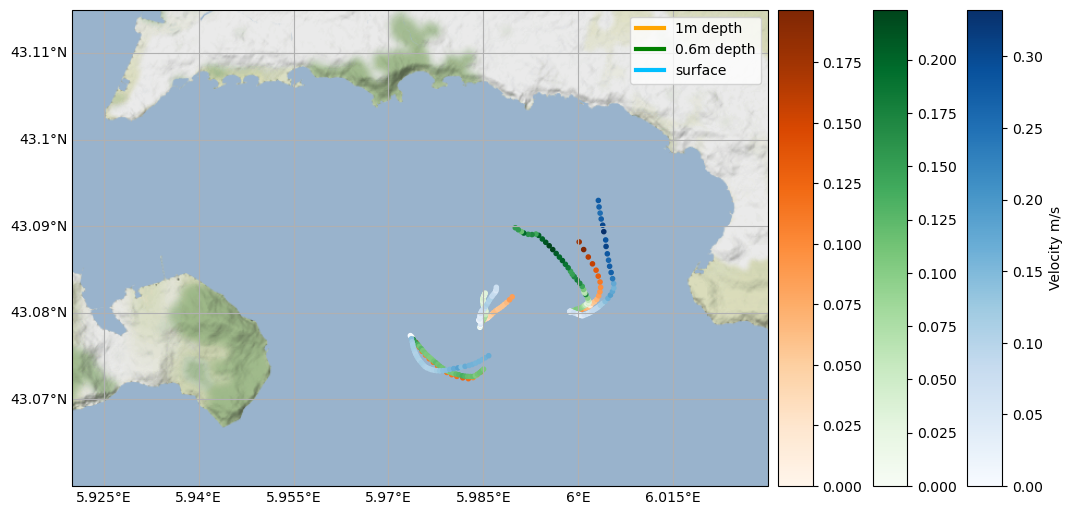

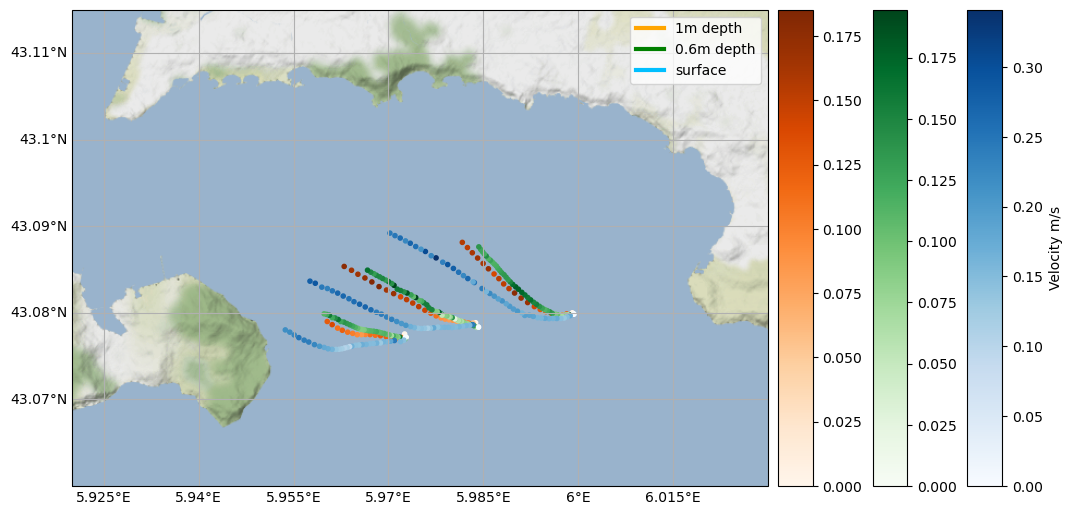

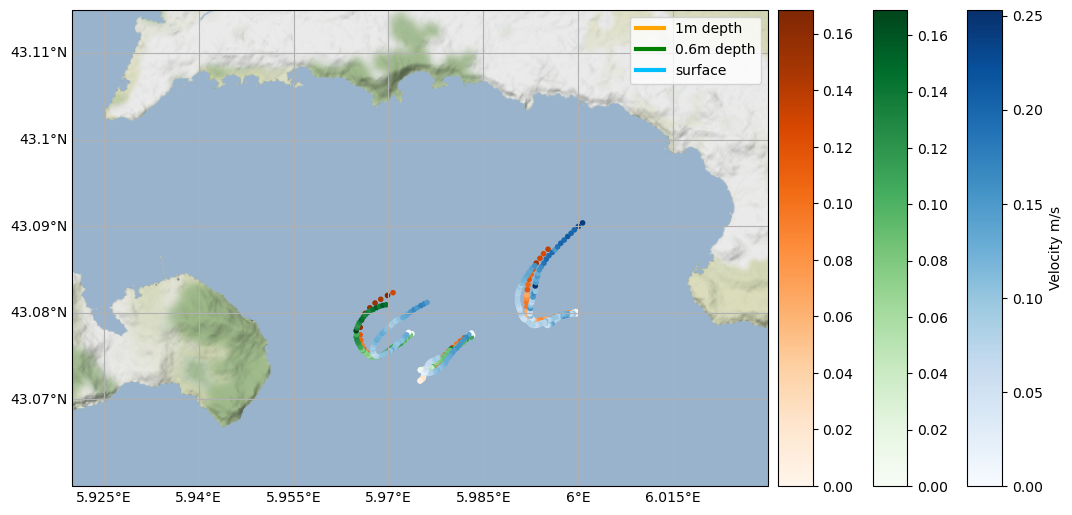

In [9]:
for day,data in clean_data_per_day.items():
    
    #Load terrain background from http://maps.stamen.com (implemented in cartopy.cimgt)
    stamen_terrain = cimgt.Stamen('terrain-background')
    fig = plt.figure(figsize=(12, 10))

    # Create a GeoAxes in the tile's projection.
    ax = fig.add_subplot(projection=stamen_terrain.crs)
    ax.add_image(stamen_terrain, 13)
    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([ 5.92, 6.03, 43.06, 43.115], crs=ccrs.Geodetic())
    
    #add gridline and make them visible
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    #load each data
    yellow_drifters_df = data['1m']
    white_drifters_60_df = data['60cm']
    white_drifters_surface_df = data['surface']
    
    #Now lets plot the trajectories !
    #first we concat all the data in one df per type of drifter
    drifters_0 = pd.concat(
        [ i for k,i in white_drifters_surface_df.items()]
    )
    drifters_06 = pd.concat(
        [ i for k,i in white_drifters_60_df.items() ]
    )
    drifters_1 = pd.concat(
        [ i for k,i in yellow_drifters_df.items() ]
    )
    #now we plot the whole thing
    #get the data as numpy arrays
    lats_1 = drifters_1['Latitude'].to_numpy()
    lons_1 = drifters_1['Longitude'].to_numpy()
    vels_1 = drifters_1['velocity'].to_numpy()

    lats_06 = drifters_06['Latitude'].to_numpy()
    lons_06 = drifters_06['Longitude'].to_numpy()
    vels_06 = drifters_06['velocity'].to_numpy()

    lats_0 = drifters_0['Latitude'].to_numpy()
    lons_0 = drifters_0['Longitude'].to_numpy()
    vels_0 = drifters_0['velocity'].to_numpy()


    #plot the trajectories
    vels_1 = ax.scatter(lons_1,lats_1,marker='.', c=vels_1, alpha=1,cmap='Oranges', transform=ccrs.PlateCarree())
    vels_06 = ax.scatter(lons_06,lats_06,marker='.', c=vels_06, alpha=1, cmap='Greens', transform=ccrs.PlateCarree())
    vels_0 = ax.scatter(lons_0,lats_0,marker='.', c=vels_0, alpha=1, cmap='Blues', transform=ccrs.PlateCarree())


    # this code is to create a custom colorbar
    divider = make_axes_locatable(ax)
    ax_cb1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
    ax_cb2 = divider.new_horizontal(size="5%", pad=0.6, axes_class=plt.Axes)
    ax_cb3 = divider.new_horizontal(size="5%", pad=0.6, axes_class=plt.Axes)

    fig.add_axes(ax_cb1)
    fig.add_axes(ax_cb2)
    fig.add_axes(ax_cb3)

    plt.colorbar(vels_1, cax=ax_cb1)
    plt.colorbar(vels_06, cax=ax_cb2)
    plt.colorbar(vels_0, cax=ax_cb3,label=r"Velocity m/s")


    # this code is to create a custom legend
    custom_lines = [
        Line2D([0], [0],marker='.', color='orange', lw=3, markersize=1),
        Line2D([0], [0],marker='.', color='green', lw=3, markersize=1),
        Line2D([0], [0],marker='.', color='deepskyblue', lw=3, markersize=1)
    ]           
    ax.legend(custom_lines,['1m depth','0.6m depth','surface'])

    #ax.set_title(f"Drifter Trajectories {day} october 2022")


## WIND

In this part we are going to visualize the wind data for every day

In [10]:
from scipy.io import loadmat

In [11]:
#Load our model data
model = loadmat('./model_data/AROME_2022_Oct.mat')
#Get the velocity field components for depth=0
u = np.moveaxis(model['U_Arome'],0,1)
v = np.moveaxis(model['V_Arome'],0,1)
norm = np.sqrt(v**2+u**2)

#create a xarray dataset (efficient for spatio-temporal grids)
wind_ds = xr.Dataset(
    coords = dict(
        lon = model['XX'][:,0],
        lat = model['YY'][0,:],
        time = model['time'][0],
    ),
    data_vars = dict(
        u = ( ['lat', 'lon', 'time'], u),
        v =  ( ['lat', 'lon', 'time'], v),
        norm = ( ['lat', 'lon', 'time'], norm),
    )
)

In [14]:

lats = np.linspace(43.06,43.11,18)
lons = np.linspace(5.925,6.03,18)
wind_d1 = wind_ds.sel(lon=lons,lat=lats,time=[738805.375,738805.5,738805.625],method='nearest')
wind_d2 = wind_ds.sel(lon=lons,lat=lats,time=[738805.375,738805.5,738805.625],method='nearest')
wind_d3 = wind_ds.sel(lon=lons,lat=lats,time=[738805.375,738805.5,738805.625],method='nearest')

winds = [wind_d1,wind_d2,wind_d3]

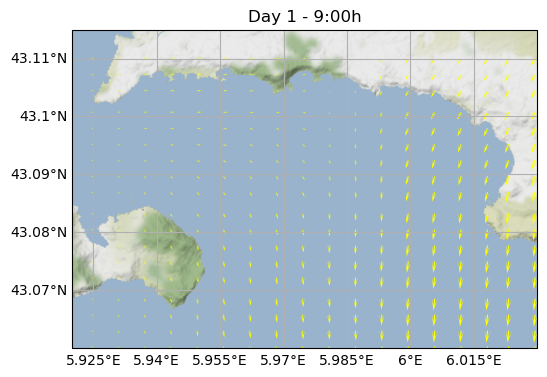

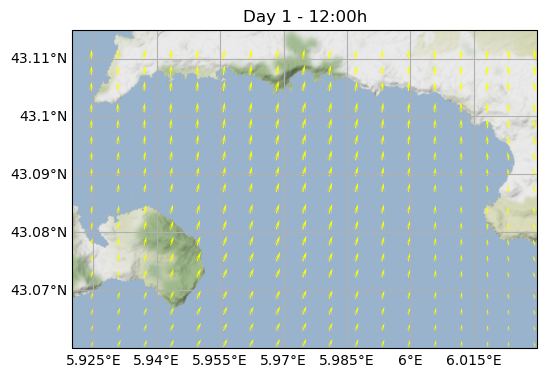

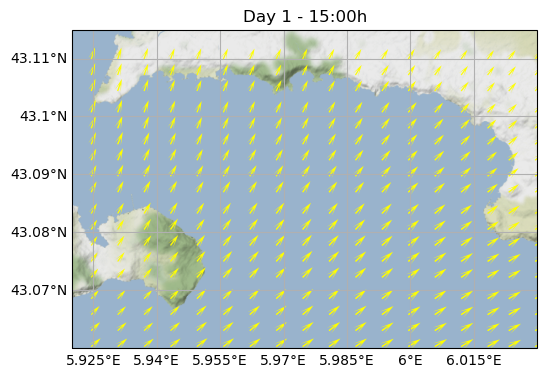

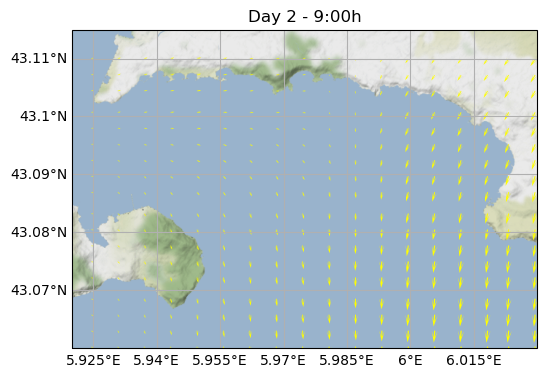

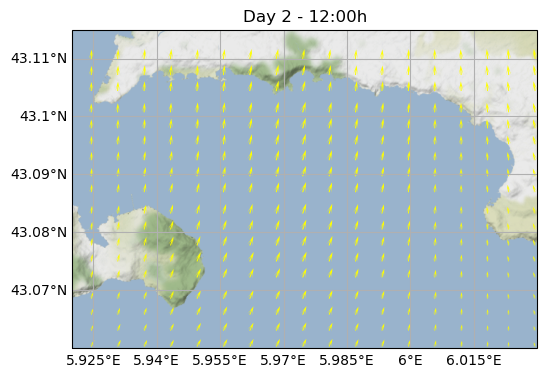

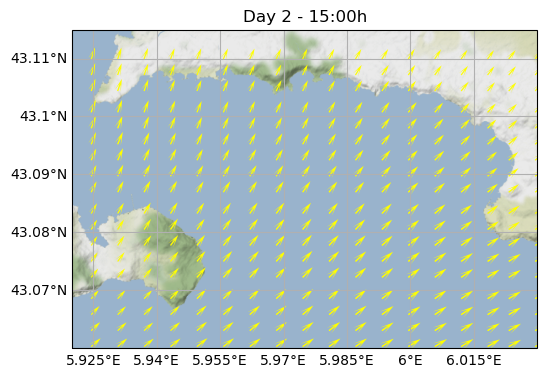

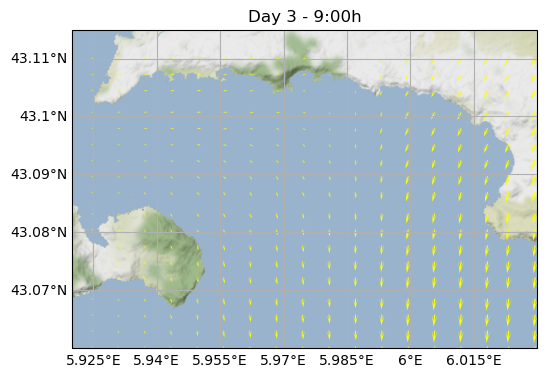

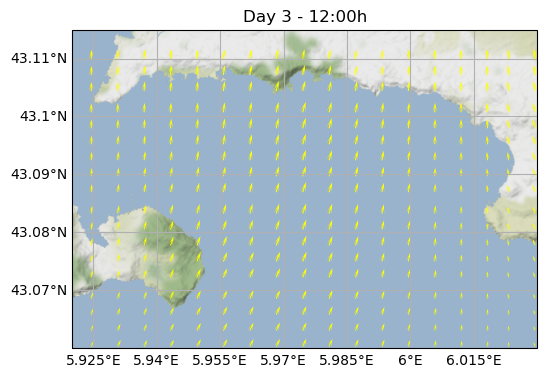

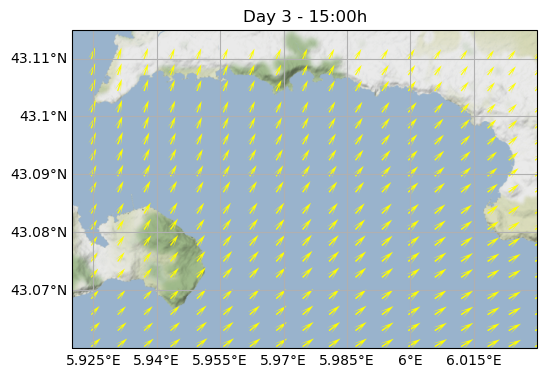

In [17]:
for day,data in enumerate(winds):
    for i in range(3):
        
        stamen_terrain = cimgt.Stamen('terrain-background')
        fig = plt.figure(figsize=(6,6))

        # Create a GeoAxes in the tile's projection.
        ax = fig.add_subplot(projection=stamen_terrain.crs)
        ax.add_image(stamen_terrain, 13)
        # Limit the extent of the map to a small longitude/latitude range.
        ax.set_extent([ 5.92, 6.03, 43.06, 43.115], crs=ccrs.Geodetic())

        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        #plot vector field
        ax.quiver(
            data['lon'].data,
            data['lat'].data,
            data['u'].data[:,:,i],
            data['v'].data[:,:,i],
            transform=ccrs.PlateCarree(),
            color='yellow',
            scale=110,
            headwidth=5,
            headlength=10,
            angles='xy'
        )
        #convert ordinal decimals to hour of day
        hour = int(data['time'][i].data % 1 *24)
        ax.set_title(f'Day {day+1} - {hour}:00h')

    